<h1><b>Colorize Grayscale Image using CGAN</h1></b>






<h5><b>Importing all the necessary packages.

In [ ]:
#import
import os
import cv2
import pickle
from PIL import Image
from skimage import color
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, LeakyReLU, Activation, Concatenate, Dropout, BatchNormalization, Input

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<h5><b>The images used in this project were downloaded from unsplash.com. Around 1100 coastal images were downloaded and divided into train and test folder later.

<h5><b>The downloaded images were of different size . So, following code will resize all the images into 256 * 256 dimension. PIL is a famous python imaging library, and it was used for resizing images.

In [ ]:
#Resize the image
import os
from PIL import Image
path = os.chdir("/home/prashish/Downloads/wallpaper")
newsize = (256,256)
for file in os.listdir(path):
        img = Image.open(file)
        img = img.resize(newsize)
        img.save(file)


<h5><b> After resizing the images, the corresponding grayscale version of all colored(original) images were created using PIL. Following code depicts this.

In [ ]:
#create a grayscale image
import os
from PIL import Image
path = os.chdir("/home/prashish/Downloads/wallpapergray")
for file in os.listdir(path):
    img = Image.open(file)
    img_gray = img.convert('LA').convert('RGB')
    img_gray.save(file)

<h5><b>Later, all grayscale and color images were arranged into 2 seperate folder(Gray & Color) and splitted between Train and Val folders.

<h5><b><i> load_images() function allows us to load both grayscale and color images from the directory and convert them into a numpy array.

In [ ]:
def load_images(filepath):
  """ 
  Function to load all images(both grayscale and color) from directory( where image is stored) into a memory 
   """
  img_list = list()
    # enumerate through all files in directory, assuming all are images of size 256 * 256
  for file in sorted(os.listdir(filepath)):
    # load and resize the images from the filepath using keras image preprocessing function
    pixels = load_img(filepath + file)
    # convert to numpy array using keras image preprocessing
    pixels = img_to_array(pixels)
    # append to img_list()
    img_list.append(pixels)
  return [np.asarray(img_list)]

<h5><b> gray_img_path</b> is a path to grayscale images in Train folder and <b>color_img_path</b> is path to color images in Train folder.

In [ ]:
# Image path
gray_img_path = '/content/drive/MyDrive/DL Datasets/GrayToColor/Train/Gray/'
color_img_path = '/content/drive/MyDrive/DL Datasets/GrayToColor/Train/Color/'

<h5><b> All grayscale and color images were loaded as  2 seperate numpy arrays into a memory.

In [ ]:
# load dataset
[gray_images] = load_images(gray_img_path)
[color_images] = load_images(color_img_path)

<h5>Shape of <b>gray_images</b> and <b>color_images</b> numpy array

In [ ]:
print('Loaded: ', gray_images.shape, color_images.shape)

Loaded:  (1000, 256, 256, 3) (1000, 256, 256, 3)


<h5><b>Plotting one of the images from gray_images numpy array.

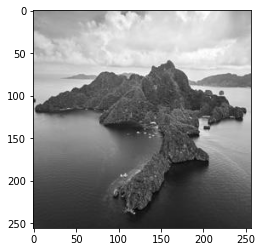

In [ ]:
plt.imshow(gray_images[100].astype('uint8'))

<h5><b>Plotting one of the images from color_images numpy array.

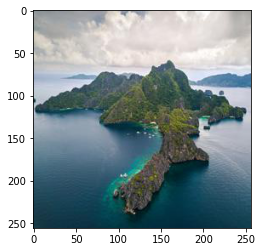

In [ ]:
plt.imshow(color_images[100].astype('uint8'))

<h3><b>Compress and save as np array

<h5><b>Following code compresses both gray_images and color_images into .npz file and saves it, so that it can be used for future use. This prevents tedious task of reloading all the images from the directory which is much slower.

In [ ]:
# save as compressed numpy array
filename = 'dataset.npz'
np.savez_compressed(filename, gray_images, color_images)
print('Saved dataset', filename)

Saved dataset dataset.npz


<h3><b>Load Prepared Dataset

<h5><b>Now, we can directly load our image dataset from the compressed .npz file.

In [ ]:
dataset = np.load('/content/drive/MyDrive/DL Datasets/GrayToColor/dataset.npz')
gray_images, color_images = dataset['arr_0'], dataset['arr_1']
print('Loaded: ', gray_images.shape, color_images.shape)

Loaded:  (1000, 256, 256, 3) (1000, 256, 256, 3)


<h5><b>Plotting one of the images from gray_images numpy array.

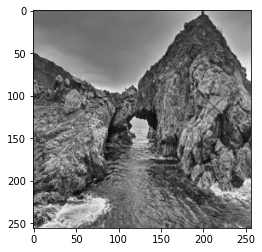

In [ ]:
plt.imshow(gray_images[200].astype('uint8'))

<h5><b>lotting one of the images from color_images numpy array.

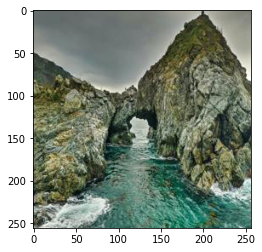

In [ ]:
plt.imshow(color_images[200].astype('uint8'))

<h3><b>Plotting the grayscale and colored images.</b></h3>

<h5><b>Following code plots the 6 grayscale and color images into the subplot. 

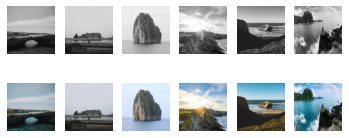

In [ ]:
#Define total no of sample iamges to be plotted
sample_no = 6

#plotting grayscale images
for i in range(sample_no):
  plt.subplot(3, sample_no, 1 +i)
  plt.axis('off')
  plt.imshow(gray_images[i].astype('uint8'))

#plotting color images
for i in range(sample_no):
  plt.subplot(3, sample_no, 1+ sample_no + i)
  plt.axis('off')
  plt.imshow(color_images[i].astype('uint8'))

plt.show()

<h2><b>Building the Architecture

<b>Conditional generative adversarial network (cGAN) </b>is an extension of the <b>generative adversarial network (GAN)</b> that's used as a machine learning framework for training generative models. The idea was first published in a 2014 paper titled Conditional Generative Adversarial Nets by Mehdi Mirza and Simon Osindero.

<b>CGAN is a deep learning method where a conditional setting is applied, meaning that both the generator and discriminator are conditioned on some sort of auxiliary information such as class labels or data from other modalities. As a result, the ideal model can learn multi-modal mapping from inputs to outputs by feeding it with different contextual information

<b>In this project, I have used Pix2Pix GAN.The Pix2Pix model is a type of conditional GAN, or cGAN, where the generation of the output image is conditional on an input, in this case, a source image. The discriminator is provided both with a source image and the target image and must determine whether the target is a plausible transformation of the source image. The generator is then updated with both adversial loss and L1 loss. Adversial loss helps generator to generate more realistic images in target domain. L1 loss which is measured between generated image and expected output image encourages generator to create more realistic translation of source images.

The architecture and hyperparameter used in this project is described by Philip Isola and his team in the paper entitled <b>"Image-to-Image Translation with Conditional Adversarial Networks".</b> Link:https://arxiv.org/abs/1611.07004

<h3><b>Define the Discriminator model </b></h3>

<h5><b>The discriminator() function below implements 70*70 patch GAN discriminator model which takes 2 input images that are concatenated together and predicts the patch output of predictions.

In [ ]:
# define the discriminator model
def discriminator(image_shape):
	# initialization of weight
	init = RandomNormal(stddev=0.02)
	# gray image input
	in_gray_image = Input(shape=image_shape)
	# color image input
	in_color_image = Input(shape=image_shape)
	# concatenate both gray images and color images channel wise
	merged = Concatenate()([in_gray_image, in_color_image])
	# C64
	disc = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
	disc = LeakyReLU(alpha=0.2)(disc)
	# C128
	disc = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(disc)
	disc = BatchNormalization()(disc)
	disc = LeakyReLU(alpha=0.2)(disc)
	# C256
	disc = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(disc)
	disc = BatchNormalization()(disc)
	disc = LeakyReLU(alpha=0.2)(disc)
	# C512
	disc = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(disc)
	disc = BatchNormalization()(disc)
	disc = LeakyReLU(alpha=0.2)(disc)
	# second last output layer
	disc = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(disc)
	disc = BatchNormalization()(disc)
	disc = LeakyReLU(alpha=0.2)(disc)
	# patch output
	disc = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(disc)
	output_patch = Activation('sigmoid')(disc)
	# define model
	model = Model([in_gray_image, in_color_image], output_patch)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
	return model


<h3><b>Define the Generator model

<h5><b> The generator model is based on the U-net architecture which consist of encoder block layer,bottleneck layer and decoder block.Here, skip connection connects encoding layer and decoding layer.Generator takes input grayscale image and tries to generate corresponding color image.

In [ ]:
# define an encoder block
def encoder_block(layer_in, n_filters, batchnorm=True):
	# initialization of weight
	init = RandomNormal(stddev=0.02)
	# adding downsampling layer
	gen = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# conditionally adding batch normalization
	if batchnorm:
		gen = BatchNormalization()(gen, training=True)
	# leaky relu activation
	gen = LeakyReLU(alpha=0.2)(gen)
	return gen
 
# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	# initialization of weight
	init = RandomNormal(stddev=0.02)
	# adding upsampling layer
	gen = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# adding batch normalization
	gen = BatchNormalization()(gen, training=True)
	# conditionally adding dropout
	if dropout:
		gen = Dropout(0.5)(gen, training=True)
	# merge with skip connection
	gen = Concatenate()([gen, skip_in])
	# relu activation
	gen = Activation('relu')(gen)
	return gen
 
# define the standalone generator model
def generator(image_shape=(256,256,3)):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	input_image = Input(shape=image_shape)
	# encoder model
	encoder1 = encoder_block(input_image, 64, batchnorm=False)
	encoder2 = encoder_block(encoder1, 128)
	encoder3 = encoder_block(encoder2, 256)
	encoder4 = encoder_block(encoder3, 512)
	encoder5 = encoder_block(encoder4, 512)
	encoder6 = encoder_block(encoder5, 512)
	encoder7 = encoder_block(encoder6, 512)
	# bottleneck layer, no batch normalization and relu
	bottleneck = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(encoder7)
	bottleneck = Activation('relu')(bottleneck)
	# decoder model
	decoder1 = decoder_block(bottleneck, encoder7, 512)
	decoder2 = decoder_block(decoder1, encoder6, 512)
	decoder3 = decoder_block(decoder2, encoder5, 512)
	decoder4 = decoder_block(decoder3, encoder4, 512, dropout=False)
	decoder5 = decoder_block(decoder4, encoder3, 256, dropout=False)
	decoder6 = decoder_block(decoder5, encoder2, 128, dropout=False)
	decoder7 = decoder_block(decoder6, encoder1, 64, dropout=False)
	# output
	gen = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(decoder7)
	output_image = Activation('tanh')(gen)
	# define model
	model = Model(input_image, output_image)
	return model

<h3><b>Define composite model

<h5><b> The composite model is defined which is used for updating the generator via the discriminator.In this model we make the weights in the discriminator non trainable.

In [ ]:
#define the combined generator and discriminator model, for updating the generator
def define_gan(gen_model, disc_model, image_shape):
  #make weights in the discriminator not trainable
  disc_model.trainable = False
  #define the source image
  in_src_gray = Input(shape = image_shape)
  #connect the source image to the generator input
  generator_out = gen_model(in_src_gray)
  #connect the source input and generator output to the discriminator input
  discriminator_out = disc_model([in_src_gray, generator_out])
  #src image as input, generated image and classification output
  model = Model(in_src_gray, [discriminator_out, generator_out])
  #compile model
  opt = Adam(lr = 0.0002, beta_1 = 0.5)
  model.compile(loss = ['binary_crossentropy','mae'], optimizer = opt, loss_weights = [1,100])
  return model

<h3><b>Load and prepare the real samples

<h5><b> load_real_samples() function loads real sample of grayscale and color images from the dataset.

In [ ]:
#load and prepare training images
def load_real_samples(filename):
  #load compressed arrays
  dataset = np.load(filename)
  #unpack the arrays
  X1, X2 = dataset['arr_0'], dataset['arr_1']
  #scale from [0,255] to [-1,1]
  X1 = (X1 - 127.5)/127.5
  X2= (X2 - 127.5)/ 127.5
  return [X1, X2]

<h5><b>Since,training Discriminator require batches of real and fake images
gen_real_samples will prepare a batch of random pairs of images from the training dataset, and the corresponding discriminator label of class = 1 to indicate they are real.

In [ ]:
#select a batch of random samples, returns images and target
def gen_real_samples(dataset, n_samples, patch_shape):
  #unpack the dataset
  train_A, train_B = dataset
  #choose random instances
  ix = np.random.randint(0, train_A.shape[0], n_samples)
  #retrieve selected images
  X1, X2 = train_A[ix], train_B[ix]
  #generate 'real' class labels(1)
  y = np.ones((n_samples, patch_shape, patch_shape, 1))
  return [X1, X2], y

<h5><b> Similarly, gen_fake_samples function  uses generator model and a batch of grayscale images to generate an equivalent batch of fake colored images for the discriminator.

In [ ]:
#generate a batch of fake images, return images and targets
def gen_fake_samples(gen_model, samples, patch_shape):
  #generate fake instance
  X = gen_model.predict(samples)
  #create 'fake' class labels (0)
  y = np.zeros((len(X), patch_shape, patch_shape, 1))
  return X,y

<h3><b>Define the function to summarize performance

<h5><b>summarize_performance() function below will create a subplot of grayscale images, generated color images and real color images every 10 epoch.Similarly, it will save generator model every 10 epoch. At the end of training we can choose the model which performs best and use it for future grayscale image to color image translation. 

In [ ]:
#generate  samples and save as a plot and save the model
def summarize_performance(step, gen_model, dataset, n_samples = 3):
  #select a sample of input iamges
  [X_real_A, X_real_B], _ = gen_real_samples(dataset, n_samples, 1)
  #generate a batch of fake samples
  X_fake_B, _ = gen_fake_samples(gen_model, X_real_A, 1)
  #scale all pixels from [-1, 1] to [0,1]
  X_real_A = (X_real_A + 1) / 2.0
  X_real_B = (X_real_B + 1) / 2.0
  X_fake_B = (X_fake_B + 1) / 2.0
  #plot the real gray images
  for i in range(n_samples):
    plt.subplot(3, n_samples, 1 +i)
    plt.axis('off')
    plt.imshow(X_real_A[i])

  #plot the generated color image
  for i in range(n_samples):
    plt.subplot(3, n_samples, 1 + n_samples + i)
    plt.axis('off')
    plt.imshow(X_fake_B[i])

  #plot real color image
  for i in range(n_samples):
    plt.subplot(3, n_samples, 1 + n_samples*2 +i)
    plt.axis('off')
    plt.imshow(X_real_B[i])

  #save a plot to file
  filename1 = 'plot_%06d.png' % (step+1)
  plt.savefig(filename1)
  plt.close()

  #save the generator model
  filename2 = 'model_%06d.h5' % (step+1)
  gen_model.save(filename2)
  print('>Saved: %s and %s' % (filename1, filename2))

<b>The train() function below takes the  generator, discriminator, composite model, and loaded dataset as input. The number of epochs is set at 100 to keep training times down. A batch size of 1 is used as  recommended in the paper. Since there are 1000 images in the training dataset, and epoch of 100 is used, generator will be evaluated and saved every 10 epochs or 10000 training steps.The model will run for 100000 training step(100 epoch) and loss for each update will be displayed in the console.

In [ ]:
# train pix2pix model
def train(disc_model, gen_model, gan_model, dataset, n_epochs=100, n_batch=1):
	# determine the output square shape of the discriminator
	n_patch = disc_model.output_shape[1]
	# unpack dataset
	train_A, train_B = dataset
	# calculate the number of batches per training epoch
	batch_per_epoch = int(len(train_A) / n_batch)
	# calculate the number of training iterations
	n_steps = batch_per_epoch * n_epochs
	# manually enumerate epochs
	for i in range(n_steps):
		# select a batch of real samples
		[X_real_A, X_real_B], y_real = gen_real_samples(dataset, n_batch, n_patch)
		# generate a batch of fake samples
		X_fake_B, y_fake = gen_fake_samples(gen_model, X_real_A, n_patch)
		# update discriminator for real samples
		disc_loss1 = disc_model.train_on_batch([X_real_A, X_real_B], y_real)
		# update discriminator for generated samples
		disc_loss2 = disc_model.train_on_batch([X_real_A, X_fake_B], y_fake)
		# update the generator
		gen_loss, _, _ = gan_model.train_on_batch(X_real_A, [y_real, X_real_B])
		# summarize performance
		print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, disc_loss1, disc_loss2, gen_loss))
		# summarize model performance
		if (i+1) % (batch_per_epoch * 10) == 0:
			summarize_performance(i, gen_model, dataset)

<b>Loading the image dataset

In [ ]:
# load image data
dataset = load_real_samples('/content/drive/MyDrive/DL Datasets/GrayToColor/dataset.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)

Loaded (1000, 256, 256, 3) (1000, 256, 256, 3)


<b>Defining the input shape of the dataset

In [ ]:
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]

In [ ]:
print(image_shape)

(256, 256, 3)


<b>Defining the generator and discriminator models

In [ ]:
# define the models
disc_model = discriminator(image_shape)
gen_model = generator(image_shape)

<b> Defining composite gan model

In [ ]:
# define the composite model
gan_model = define_gan(gen_model, disc_model, image_shape)

<b>Training model

In [ ]:
# train model
train(disc_model, gen_model, gan_model, dataset)

<h3><b>Using Pretrained model for image translation

<h5><b>After training is complete, we can check for the best image generated by the generator. The final generator model for image translation can be choosen on the basis of generated image quality.

Here, plot_images() function below loads the random sample of grayscale and color image from the training dataset. Then the grayscale image is fed to generator model to generate color image. At last, subplot of grayscale image, generated color image and real color image is displayed.

Loaded (1000, 256, 256, 3) (1000, 256, 256, 3)


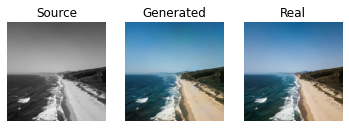

In [ ]:
# example of loading a pix2pix model and using it for image to image translation
#load and prepare training images
def load_real_samples(filename):
  #load compressed arrays
  data = np.load(filename)
  #unpack arrays
  X1, X2 = data['arr_0'], data['arr_1']
  #scale from [0,255] to [-1,1]
  X1 = (X1 - 127.5) / 127.5
  X2 = (X2 - 127.5) / 127.5
  return [X1, X2]


#plot source, generated and real images
def plot_images(src_gray_img, gen_color_img, real_color_img):
  images = np.vstack((src_gray_img, gen_color_img, real_color_img))
  #scale from [-1, 1] to [0,1 ]
  images = (images + 1) / 2.0
  titles = ['Source', 'Generated', 'Real']
  #plot images row by row
  for i in range(len(images)):
    #define subplot
    plt.subplot(1, 3, 1 + i)
    #turn off the axis
    plt.axis('off')
    #plot raw pixel data
    plt.imshow(images[i])
    #show title
    plt.title(titles[i])
  plt.show()

# load dataset
[X1, X2] = load_real_samples('/content/drive/MyDrive/DL Datasets/GrayToColor/dataset.npz')
print('Loaded', X1.shape, X2.shape)
# load model
model = load_model('/content/drive/MyDrive/DL Datasets/GrayToColor/model.h5')
# select random example
ix = np.random.randint(0, len(X1), 1)
src_gray_image, real_color_image = X1[ix], X2[ix]
# generate image from source
gen_color_image = model.predict(src_gray_image)
# plot all three images
plot_images(src_gray_image, gen_color_image, real_color_image)

<h3><b>Using model for one off image transalation

<h5><b>We can also use generator model for one off image translation.
Below, the specific grayscale image is choosen from the validation set and fed to generator model. Then the subplot of grayscale image and generated color image is displayed. 

Loaded (1, 256, 256, 3)


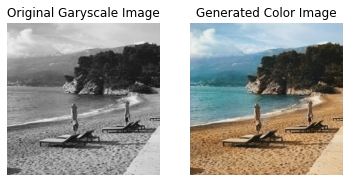

In [ ]:
# load an image
def load_image(filename, size=(256,256)):
	# load image with the preferred size
	pixels = load_img(filename, target_size=size)
	# convert to numpy array
	pixels = img_to_array(pixels)
	# scale from [0,255] to [-1,1]
	pixels = (pixels - 127.5) / 127.5
	# reshape to 1 sample
	pixels = np.expand_dims(pixels, 0)
	return pixels
 
# load source grayscale image
src_gray_image = load_image('/content/drive/MyDrive/DL Datasets/GrayToColor/Val/Gray/1010.jpg')
print('Loaded', src_gray_image.shape)
# load model
model = load_model('/content/drive/MyDrive/DL Datasets/GrayToColor/model.h5')
# generate color image from source
gen_color_image = model.predict(src_gray_image)
# scale from [-1,1] to [0,1]
src_gray_image = (src_gray_image + 1) / 2.0
gen_color_image = (gen_color_image + 1) / 2.0
# plot the image
plt.subplot(1,2,1)
plt.imshow(src_gray_image[0])
plt.title("Original Garyscale Image")
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(gen_color_image[0])
plt.title("Generated Color Image")
plt.axis('off')
plt.show()